# Photometry

This notebook goes through photometry on multiple images that are aligned.

In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['image.interpolation'] = 'none'
from astropy.io import fits
from astropy import stats
from scipy import ndimage
from astropy.table import Table, Column
from astropy import table
pl.style.use('dark_background')
from astropy.stats import mad_std

In [2]:
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry, CircularAperture

We're going to use both our combined, aligned images (you should use your final reduced, combined images here) and uncertainty frames:

In [3]:
fh = fits.open('NGCSomething_median_combined_V.fits')
background = np.median(fh[0].data)
bgsub_V = fh[0].data - background
uncertainty_V = fits.getdata('NGCSomething_uncertainty_V.fits')

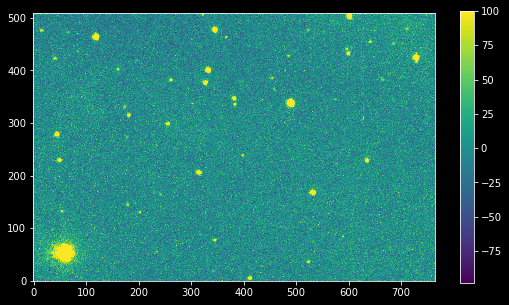

In [4]:
pl.figure(figsize=(9,5))
pl.imshow(bgsub_V, vmax=100)
pl.colorbar()

We need to estimate the background noise level to give to our photometry routine (you need this no matter which photometry routine you use)

In [5]:
# estimate the background noise
# two ways to do this are to take the std dev of the background:
background_stddev = mad_std(bgsub_V)
# or to take the mean or median of the uncertainty image:
background_stddev = np.median(uncertainty_V)
background_stddev

21.35337138135146

We then need to cut out a star and measure its FWHM, because we need to give a FWHM guess to DAOPhot.

FWHM average, in pixels: 6.146991971581738


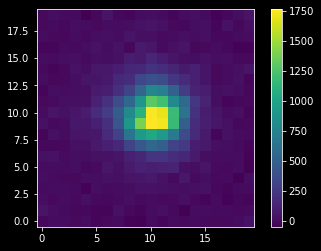

In [6]:
cx,cy = 532,168
star_cutout = bgsub_V[cy-10:cy+10, cx-10:cx+10]
pl.imshow(star_cutout); pl.colorbar()
yc, xc = np.indices(star_cutout.shape)
mom1_x = (xc * star_cutout).sum() / star_cutout.sum()
mom1_y = (yc * star_cutout).sum() / star_cutout.sum()
mom2_x = ((xc - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
mom2_y = ((yc - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
sigma_to_fwhm = np.sqrt(8*np.log(2))
fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
avg_fwhm = (fwhm_x*fwhm_y)**0.5
print(f"FWHM average, in pixels: {avg_fwhm}")

We then run DAOPhot to automatically extract the stars from the image.

In [7]:
# 4.5-sigma threshold was determined by guess-and-check
daofind = DAOStarFinder(fwhm=avg_fwhm, threshold=4.5*background_stddev)  
sources_V = daofind(bgsub_V)

In [8]:
sources_V

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64
1,412.32226091327726,4.454417657783118,0.4678626911464587,0.1166919283575839,-0.14611496536766702,49,0.0,318.7224487782004,5.0220490135592195,-1.7522023674249518
2,524.395650698649,36.60810298623848,0.4585280906290881,-0.04895156548733161,-0.08834856233576814,49,0.0,160.46413253710728,2.5799104759460594,-1.0290115900270778
3,62.80152680553008,52.14099586749775,0.41214645451875603,-0.025467892478472757,-0.15978435016300516,49,0.0,99796.33185233515,1679.2925992582768,-8.062815935062147
4,234.90047245197448,55.652266592823885,0.5686032046267451,0.1350415316667007,0.1050447672116597,49,0.0,73.42516790226091,1.1043519042657415,-0.10776871094752263
5,346.1218232081367,77.49393628138374,0.6761398068532941,0.21735072612549658,-0.288184813670124,49,0.0,151.75223264863536,1.8441330111438896,-0.6644806051380319
6,589.1243749929839,84.07776588611777,0.3958372644383514,0.4647156709626752,-0.17403891138448968,49,0.0,73.12540011465848,1.35018422267508,-0.3259825720390069
7,661.0501077366088,111.11060435833711,0.2681131516191789,0.3328481843884077,0.7760707644640955,49,0.0,33.12265231266923,1.0645168554767375,-0.06788135603421548
8,202.5924437202105,130.83069655924731,0.2730024310425074,-0.0781729430962552,0.010092079118554574,49,0.0,97.92531187004215,2.235183862103758,-0.8732831330019173
9,55.614882744991434,132.4025657548193,0.4461109832616089,-0.4541918397431229,-0.01622398777123665,49,0.0,100.2845331579947,1.6417391985067848,-0.5382604190393543


We then do _aperture photometry_ to get the fluxes and uncertainties per star.

Aperture photometry is just taking the sum of the flux within a region, in this case, within a circle centered on the star with radius equal to the FWHM of the star.

In [9]:
positions = np.transpose((sources_V['xcentroid'], sources_V['ycentroid']))  
apertures_V = CircularAperture(positions, r=avg_fwhm)  
phot_table_V = aperture_photometry(bgsub_V, apertures_V, error=uncertainty_V)  
for col in phot_table_V.colnames:  
    phot_table_V[col].info.format = '%.3g'  # "%.3g" will print only 3 values, so it can be used for sig-fig display
phot_table_V

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,,
int32,float64,float64,float64,float64
1,412,4.45,7.85e+03,232
2,524,36.6,3.8e+03,235
3,62.8,52.1,2.77e+06,989
4,235,55.7,1.41e+03,234
5,346,77.5,3.42e+03,235
6,589,84.1,2.06e+03,234
7,661,111,614,233
8,203,131,2.83e+03,235


# ASIDE:
Aperture Photometry is basically the same thing we've been doing!

If we use our previous photometry tool:

In [10]:
def calculate_star_flux_and_error(cutout_star, cutout_uncertainty, sky_stddev):

    mask = cutout_star > 2*sky_stddev
    masked_star_sum = cutout_star[mask].sum()
    masked_star_sum_error = ((cutout_uncertainty[mask]**2).sum() + sky_stddev**2*mask.sum())**0.5
 
    return masked_star_sum, masked_star_sum_error

we could calculate similar flux values by looping over each star:

In [11]:
# equivalent to: aperture_photometry(bgsub_V, apertures_V, error=uncertainty_V)
threshold_aperture_fluxes = []
threshold_aperture_errors = []
for row in sources_V:
    xcen,ycen = row['xcentroid'], row['ycentroid']
    cutout = bgsub_V[int(row['ycentroid']-10):int(row['ycentroid']+10),
                     int(row['xcentroid']-10):int(row['xcentroid']+10),
                    ]
    uncertainty_cutout = uncertainty_V[int(row['ycentroid']-10):int(row['ycentroid']+10),
                                       int(row['xcentroid']-10):int(row['xcentroid']+10),
                                      ]
    starsum, starerror = calculate_star_flux_and_error(cutout, uncertainty_cutout, background_stddev)
    threshold_aperture_fluxes.append(starsum)
    threshold_aperture_errors.append(starerror)

The DAOPhot apertures are doing _nearly_ the same thing, but with a little bit less bookkeeping work and a little more robustness (for example, our version doesn't work very well if the star is at the edge of the image).

# END ASIDE

We can show the apertures on the image to prove that we found reasonable stars and used reasonable apertures:

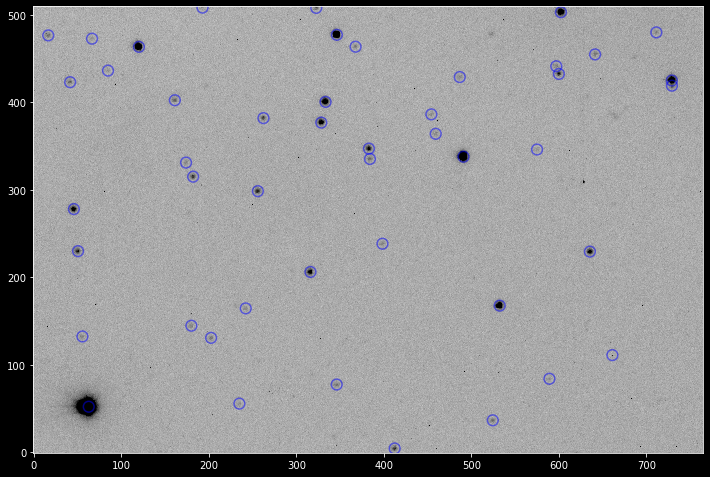

In [12]:
pl.figure(figsize=(12,12))
pl.imshow(bgsub_V, cmap='gray_r', origin='lower', vmax=400, vmin=-200)
_=apertures_V.plot(color='blue', lw=1.5, alpha=0.5)

We then combine the "source" table, which had the coordinates, with the aperture photometry table.:

In [13]:
# rename the phot_tbl columns to indicate they're V-band
for colname in phot_table_V.colnames:
    phot_table_V.rename_column(colname, "V_"+colname)
mtbl_V = table.hstack([sources_V, phot_table_V])
mtbl_V

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,V_id,V_xcenter,V_ycenter,V_aperture_sum,V_aperture_sum_err
,,,,,,,,,,,,pix,pix,,
int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,float64,float64
1,412.32226091327726,4.454417657783118,0.4678626911464587,0.1166919283575839,-0.14611496536766702,49,0.0,318.7224487782004,5.0220490135592195,-1.7522023674249518,1,412,4.45,7.85e+03,232
2,524.395650698649,36.60810298623848,0.4585280906290881,-0.04895156548733161,-0.08834856233576814,49,0.0,160.46413253710728,2.5799104759460594,-1.0290115900270778,2,524,36.6,3.8e+03,235
3,62.80152680553008,52.14099586749775,0.41214645451875603,-0.025467892478472757,-0.15978435016300516,49,0.0,99796.33185233515,1679.2925992582768,-8.062815935062147,3,62.8,52.1,2.77e+06,989
4,234.90047245197448,55.652266592823885,0.5686032046267451,0.1350415316667007,0.1050447672116597,49,0.0,73.42516790226091,1.1043519042657415,-0.10776871094752263,4,235,55.7,1.41e+03,234
5,346.1218232081367,77.49393628138374,0.6761398068532941,0.21735072612549658,-0.288184813670124,49,0.0,151.75223264863536,1.8441330111438896,-0.6644806051380319,5,346,77.5,3.42e+03,235
6,589.1243749929839,84.07776588611777,0.3958372644383514,0.4647156709626752,-0.17403891138448968,49,0.0,73.12540011465848,1.35018422267508,-0.3259825720390069,6,589,84.1,2.06e+03,234
7,661.0501077366088,111.11060435833711,0.2681131516191789,0.3328481843884077,0.7760707644640955,49,0.0,33.12265231266923,1.0645168554767375,-0.06788135603421548,7,661,111,614,233
8,202.5924437202105,130.83069655924731,0.2730024310425074,-0.0781729430962552,0.010092079118554574,49,0.0,97.92531187004215,2.235183862103758,-0.8732831330019173,8,203,131,2.83e+03,235


This is a pretty good catalog, based on the image above.

Now we do the same thing on the I-band image, except we're going to use the same apertures as in the V-band - this way, we know we're using the exact same stars!

Note that this step requires that the images are well-aligned!

In [14]:
fh_I = fits.open('NGCSomething_median_combined_I.fits')
background_I = np.median(fh_I[0].data)
bgsub_I = fh_I[0].data - background_I
uncertainty_I = fits.getdata('NGCSomething_uncertainty_I.fits')

If we overlay our V-band catalog on the I-band image, 

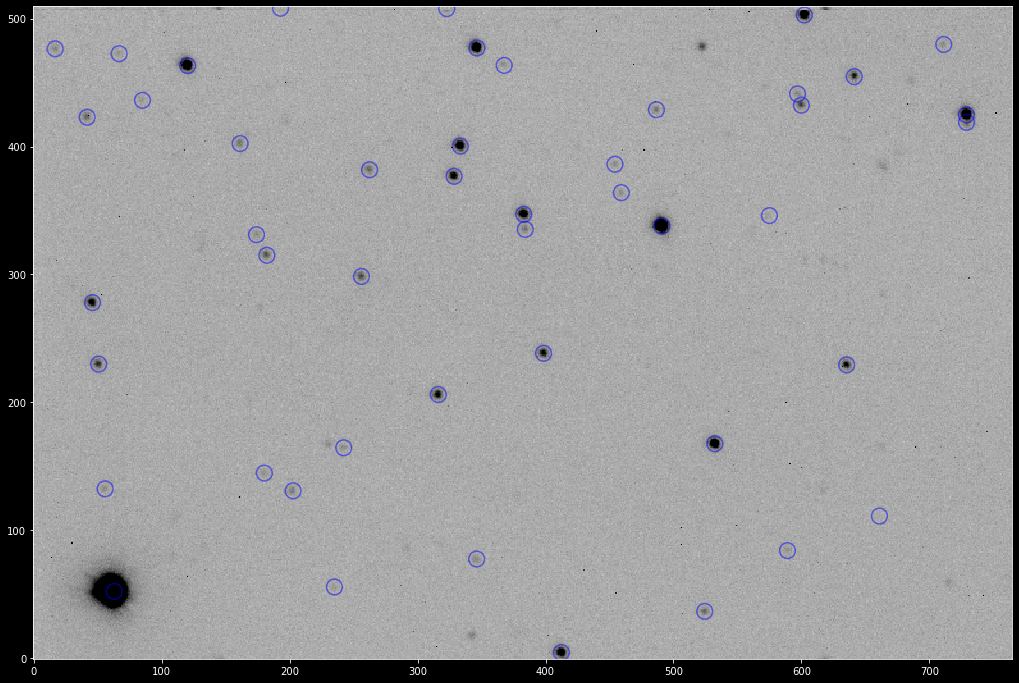

In [15]:
pl.figure(figsize=(20,12))
pl.imshow(bgsub_I, cmap='gray_r', origin='lower', vmax=400, vmin=-200)
_=apertures_V.plot(color='blue', lw=1.5, alpha=0.5)

We can see in the above image that most of the stars are the same!


Let's do B too:

In [16]:
fh_B = fits.open('NGCSomething_median_combined_B.fits')
background_B = np.median(fh_B[0].data)
bgsub_B = fh_B[0].data - background_B
uncertainty_B = fits.getdata('NGCSomething_uncertainty_B.fits')

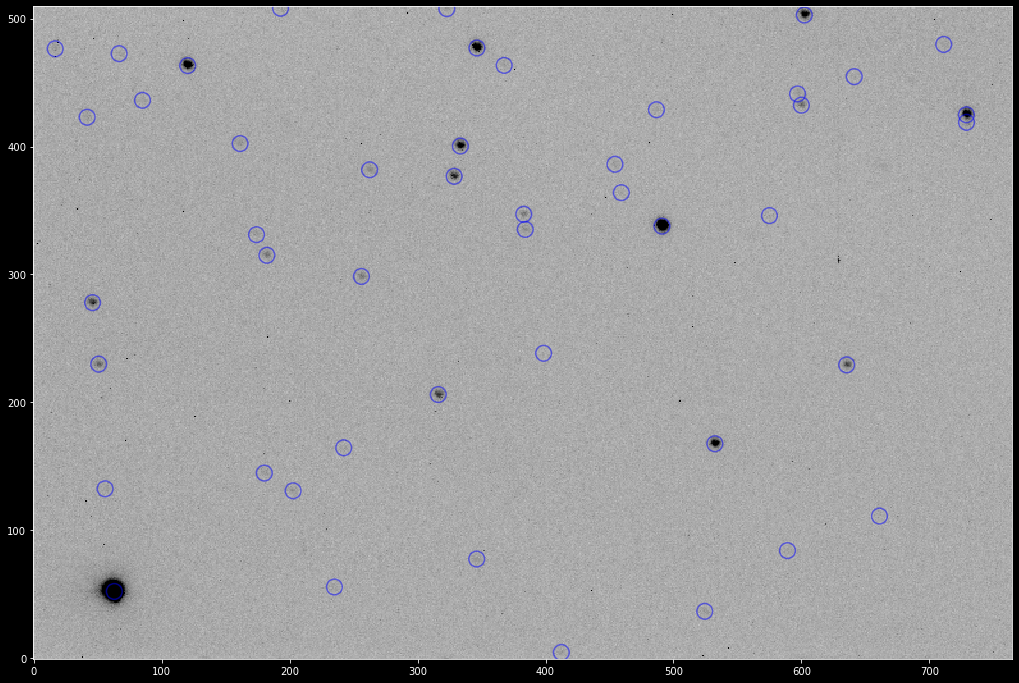

In [17]:
pl.figure(figsize=(20,12))
pl.imshow(bgsub_B, cmap='gray_r', origin='lower', vmax=400, vmin=-200)
_=apertures_V.plot(color='blue', lw=1.5, alpha=0.5)

In the B-filter, we can see that there are several stars that aren't detected.

Nonetheless, _if_ the images are well-aligned, as they are in this case, we can use the V-band apertures to extract fluxes from the I- and B-bands.

Then, we do the same column-renaming as before, and we combine all the tables into one:

In [18]:
phot_table_I = aperture_photometry(bgsub_I, apertures_V, error=uncertainty_I)
for colname in phot_table_I.colnames:
    phot_table_I.rename_column(colname, "I_"+colname)
phot_table_B = aperture_photometry(bgsub_B, apertures_V, error=uncertainty_B)
for colname in phot_table_B.colnames:
    phot_table_B.rename_column(colname, "B_"+colname)

In [19]:
full_table = table.hstack([sources_V, phot_table_V, phot_table_B, phot_table_I])
full_table

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,V_id,V_xcenter,V_ycenter,V_aperture_sum,V_aperture_sum_err,B_id,B_xcenter,B_ycenter,B_aperture_sum,B_aperture_sum_err,I_id,I_xcenter,I_ycenter,I_aperture_sum,I_aperture_sum_err
,,,,,,,,,,,,pix,pix,,,,pix,pix,,,,pix,pix,,
int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,float64,float64
1,412.32226091327726,4.454417657783118,0.4678626911464587,0.1166919283575839,-0.14611496536766702,49,0.0,318.7224487782004,5.0220490135592195,-1.7522023674249518,1,412,4.45,7.85e+03,232,1,412.32226091327726,4.454417657783118,864.1295746593231,193.27002652409735,1,412.32226091327726,4.454417657783118,27785.135384143214,213.5847084155404
2,524.395650698649,36.60810298623848,0.4585280906290881,-0.04895156548733161,-0.08834856233576814,49,0.0,160.46413253710728,2.5799104759460594,-1.0290115900270778,2,524,36.6,3.8e+03,235,2,524.395650698649,36.60810298623848,1370.6061384206587,198.65430822210348,2,524.395650698649,36.60810298623848,4723.896532671919,199.58868055528148
3,62.80152680553008,52.14099586749775,0.41214645451875603,-0.025467892478472757,-0.15978435016300516,49,0.0,99796.33185233515,1679.2925992582768,-8.062815935062147,3,62.8,52.1,2.77e+06,989,3,62.80152680553008,52.14099586749775,1175727.9417323992,656.4419086051678,3,62.80152680553008,52.14099586749775,3025422.2280554064,1023.1007209687176
4,234.90047245197448,55.652266592823885,0.5686032046267451,0.1350415316667007,0.1050447672116597,49,0.0,73.42516790226091,1.1043519042657415,-0.10776871094752263,4,235,55.7,1.41e+03,234,4,234.90047245197448,55.652266592823885,924.1371111569265,198.27937655266766,4,234.90047245197448,55.652266592823885,1299.8730053148233,196.70866841604234
5,346.1218232081367,77.49393628138374,0.6761398068532941,0.21735072612549658,-0.288184813670124,49,0.0,151.75223264863536,1.8441330111438896,-0.6644806051380319,5,346,77.5,3.42e+03,235,5,346.1218232081367,77.49393628138374,2013.5054280517124,199.19295654819936,5,346.1218232081367,77.49393628138374,3083.8743708482034,198.21444788878776
6,589.1243749929839,84.07776588611777,0.3958372644383514,0.4647156709626752,-0.17403891138448968,49,0.0,73.12540011465848,1.35018422267508,-0.3259825720390069,6,589,84.1,2.06e+03,234,6,589.1243749929839,84.07776588611777,824.4231644053473,198.19554279514978,6,589.1243749929839,84.07776588611777,2130.8209949525562,197.4114558307726
7,661.0501077366088,111.11060435833711,0.2681131516191789,0.3328481843884077,0.7760707644640955,49,0.0,33.12265231266923,1.0645168554767375,-0.06788135603421548,7,661,111,614,233,7,661.0501077366088,111.11060435833711,279.2049449480347,197.736526158872,7,661.0501077366088,111.11060435833711,164.92600555509492,195.74469229949997
8,202.5924437202105,130.83069655924731,0.2730024310425074,-0.0781729430962552,0.010092079118554574,49,0.0,97.92531187004215,2.235183862103758,-0.8732831330019173,8,203,131,2.83e+03,235,8,202.5924437202105,130.83069655924731,1593.7741618553346,198.84145321423142,8,202.5924437202105,130.83069655924731,3694.7417008451907,198.72742587571872


The table above is our final photometry table!

For display purposes, we can modify it a bit, though:

In [20]:
for col in full_table.colnames:  
    full_table[col].info.format = '%.3g'  # "%.3g" will print only 3 values, so it can be used for sig-fig display
full_table

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,V_id,V_xcenter,V_ycenter,V_aperture_sum,V_aperture_sum_err,B_id,B_xcenter,B_ycenter,B_aperture_sum,B_aperture_sum_err,I_id,I_xcenter,I_ycenter,I_aperture_sum,I_aperture_sum_err
,,,,,,,,,,,,pix,pix,,,,pix,pix,,,,pix,pix,,
int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,float64,float64
1,412,4.45,0.468,0.117,-0.146,49,0,319,5.02,-1.75,1,412,4.45,7.85e+03,232,1,412,4.45,864,193,1,412,4.45,2.78e+04,214
2,524,36.6,0.459,-0.049,-0.0883,49,0,160,2.58,-1.03,2,524,36.6,3.8e+03,235,2,524,36.6,1.37e+03,199,2,524,36.6,4.72e+03,200
3,62.8,52.1,0.412,-0.0255,-0.16,49,0,9.98e+04,1.68e+03,-8.06,3,62.8,52.1,2.77e+06,989,3,62.8,52.1,1.18e+06,656,3,62.8,52.1,3.03e+06,1.02e+03
4,235,55.7,0.569,0.135,0.105,49,0,73.4,1.1,-0.108,4,235,55.7,1.41e+03,234,4,235,55.7,924,198,4,235,55.7,1.3e+03,197
5,346,77.5,0.676,0.217,-0.288,49,0,152,1.84,-0.664,5,346,77.5,3.42e+03,235,5,346,77.5,2.01e+03,199,5,346,77.5,3.08e+03,198
6,589,84.1,0.396,0.465,-0.174,49,0,73.1,1.35,-0.326,6,589,84.1,2.06e+03,234,6,589,84.1,824,198,6,589,84.1,2.13e+03,197
7,661,111,0.268,0.333,0.776,49,0,33.1,1.06,-0.0679,7,661,111,614,233,7,661,111,279,198,7,661,111,165,196
8,203,131,0.273,-0.0782,0.0101,49,0,97.9,2.24,-0.873,8,203,131,2.83e+03,235,8,203,131,1.59e+03,199,8,203,131,3.69e+03,199


If we want to show only a subset of the columns, we can do that too:

In [21]:
full_table['id',
           'V_aperture_sum', 'V_aperture_sum_err',
           'B_aperture_sum', 'B_aperture_sum_err',
           'I_aperture_sum', 'I_aperture_sum_err'].show_in_notebook()
# .pprint(max_lines=1000, max_width=1000)

idx,id,V_aperture_sum,V_aperture_sum_err,B_aperture_sum,B_aperture_sum_err,I_aperture_sum,I_aperture_sum_err
0,1,7.85e+03,232,864,193,2.78e+04,214
1,2,3.8e+03,235,1.37e+03,199,4.72e+03,200
2,3,2.77e+06,989,1.18e+06,656,3.03e+06,1.02e+03
3,4,1.41e+03,234,924,198,1.3e+03,197
4,5,3.42e+03,235,2.01e+03,199,3.08e+03,198
5,6,2.06e+03,234,824,198,2.13e+03,197
6,7,614,233,279,198,165,196
7,8,2.83e+03,235,1.59e+03,199,3.69e+03,199
8,9,2.77e+03,235,1.44e+03,199,2.7e+03,198
9,10,2.9e+03,235,1.7e+03,199,2.16e+03,197


Some of the data have low signal-to-noise, and therefore we'll want to ignore them.  Objects with SNR < 5 are generally not well-measured:

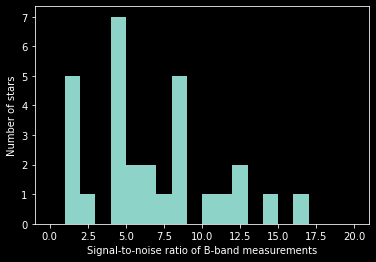

In [22]:
SNR_B = full_table['B_aperture_sum']/full_table['B_aperture_sum_err']
_=pl.hist(SNR_B, bins=np.linspace(0,20,21))
_=pl.xlabel("Signal-to-noise ratio of B-band measurements")
_=pl.ylabel("Number of stars")

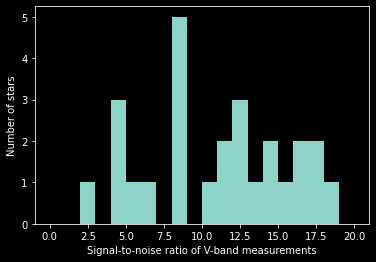

In [23]:
SNR_V = full_table['V_aperture_sum']/full_table['V_aperture_sum_err']
_=pl.hist(SNR_V, bins=np.linspace(0,20,21))
_=pl.xlabel("Signal-to-noise ratio of V-band measurements")
_=pl.ylabel("Number of stars")

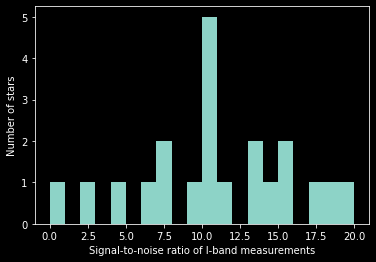

In [24]:
SNR_I = full_table['I_aperture_sum']/full_table['I_aperture_sum_err']
_=pl.hist(SNR_I, bins=np.linspace(0,20,21))
_=pl.xlabel("Signal-to-noise ratio of I-band measurements")
_=pl.ylabel("Number of stars")

It is best to use only stars with SNR > 5

In [25]:
high_snr = (SNR_B > 5) & (SNR_V > 5) & (SNR_I > 5)
high_snr.sum()

32

In [26]:
full_table['id',
           'V_aperture_sum', 'V_aperture_sum_err',
           'B_aperture_sum', 'B_aperture_sum_err',
           'I_aperture_sum', 'I_aperture_sum_err'][high_snr].show_in_notebook()

idx,id,V_aperture_sum,V_aperture_sum_err,B_aperture_sum,B_aperture_sum_err,I_aperture_sum,I_aperture_sum_err
0,2,3.8e+03,235,1.37e+03,199,4.72e+03,200
1,3,2.77e+06,989,1.18e+06,656,3.03e+06,1.02e+03
2,5,3.42e+03,235,2.01e+03,199,3.08e+03,198
3,8,2.83e+03,235,1.59e+03,199,3.69e+03,199
4,9,2.77e+03,235,1.44e+03,199,2.7e+03,198
5,10,2.9e+03,235,1.7e+03,199,2.16e+03,197
6,12,4.2e+04,261,1.94e+04,213,3.61e+04,224
7,13,1.94e+04,246,1e+04,206,1.55e+04,208
8,14,1.59e+04,244,7.2e+03,203,1.42e+04,207
9,15,1.18e+04,241,6.01e+03,203,1.04e+04,204


We calculate the magnitude and calibrate the data:

In [27]:
# we measure the magnitude zeropoints earlier...
I_magzero = 20.2
V_magzero = 20.1
B_magzero = 19.5

Imag = -2.5 * np.log10(full_table['I_aperture_sum']) + I_magzero
Vmag = -2.5 * np.log10(full_table['V_aperture_sum']) + V_magzero
Bmag = -2.5 * np.log10(full_table['B_aperture_sum']) + B_magzero

eImag = 1.09 * full_table['I_aperture_sum_err']/full_table['I_aperture_sum']
eVmag = 1.09 * full_table['V_aperture_sum_err']/full_table['V_aperture_sum']
eBmag = 1.09 * full_table['B_aperture_sum_err']/full_table['B_aperture_sum']

<ipython-input-27-9b35c003feab>:8: RuntimeWarning: invalid value encountered in log10
  Bmag = -2.5 * np.log10(full_table['B_aperture_sum']) + B_magzero


We can add these columns to the table:

In [28]:
full_table.add_column(Imag, name='M_I')
full_table.add_column(eImag, name='eM_I')
full_table.add_column(Vmag, name='M_V')
full_table.add_column(eVmag, name='eM_V')
full_table.add_column(Bmag, name='M_B')
full_table.add_column(eBmag, name='eM_B')
for col in full_table.colnames:  
    full_table[col].info.format = '%.3g'  # "%.3g" will print only 3 values, so it can be used for sig-fig display

In [29]:
full_table['id',
           'M_I', 'eM_I',
           'M_V', 'eM_V',
           'M_B', 'eM_B'][high_snr].show_in_notebook()

idx,id,M_I,eM_I,M_V,eM_V,M_B,eM_B
0,2,11,0.0461,11.2,0.0675,11.7,0.158
1,3,4,0.000369,3.99,0.000389,4.32,0.000609
2,5,11.5,0.0701,11.3,0.0749,11.2,0.108
3,8,11.3,0.0586,11.5,0.0904,11.5,0.136
4,9,11.6,0.0799,11.5,0.0925,11.6,0.151
5,10,11.9,0.0998,11.4,0.0883,11.4,0.127
6,12,8.81,0.00678,8.54,0.00677,8.78,0.012
7,13,9.72,0.0147,9.38,0.0138,9.5,0.0224
8,14,9.82,0.0159,9.59,0.0167,9.86,0.0308
9,15,10.2,0.0215,9.92,0.0223,10.1,0.0367


In [30]:
full_table.write('NGCSomething_photometry_table.fits', overwrite=True)

Now we can make a color-magnitude diagram:

Text(0, 0.5, 'V magnitude')

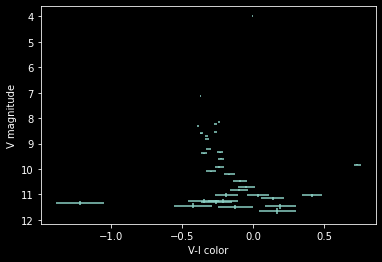

In [31]:
pl.errorbar((Vmag-Imag)[high_snr], Vmag[high_snr],
            xerr=((eImag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none')
pl.gca().invert_yaxis()
pl.xlabel("V-I color")
pl.ylabel("V magnitude")

Text(0, 0.5, 'V magnitude')

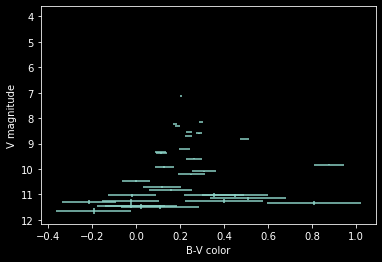

In [32]:
pl.errorbar((Bmag-Vmag)[high_snr], Vmag[high_snr],
            xerr=((eBmag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none')
pl.gca().invert_yaxis()
pl.xlabel("B-V color")
pl.ylabel("V magnitude")

Text(0, 0.5, 'I magnitude')

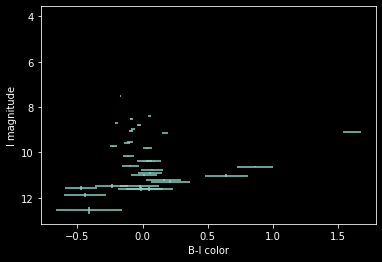

In [33]:
pl.errorbar((Bmag-Imag)[high_snr], Imag[high_snr],
            xerr=((eBmag**2+eImag**2)**0.5)[high_snr],
            yerr=eImag[high_snr], linestyle='none')
pl.gca().invert_yaxis()
pl.xlabel("B-I color")
pl.ylabel("I magnitude")

We can look at which stars are red by selecting those stars that are redder than average.  For magnitudes, B-I or B-V colors with _larger_ values are _redder_.

We select these by creating a mask, then overlay them on the image below.

In [34]:
red_stars = (Vmag-Imag) > 0.3

In [35]:
# we make an RGB image...
rgb_image = np.array([bgsub_I, bgsub_V, bgsub_B]).T.swapaxes(0,1)
rgb_image = (rgb_image - np.percentile(rgb_image, 10, axis=(0,1)))
rgb_image = np.log10(rgb_image)
rgb_image[np.isnan(rgb_image)] = 0
rgb_image /= np.percentile(rgb_image, 99.95)

<ipython-input-35-877518f59634>:4: RuntimeWarning: invalid value encountered in log10
  rgb_image = np.log10(rgb_image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


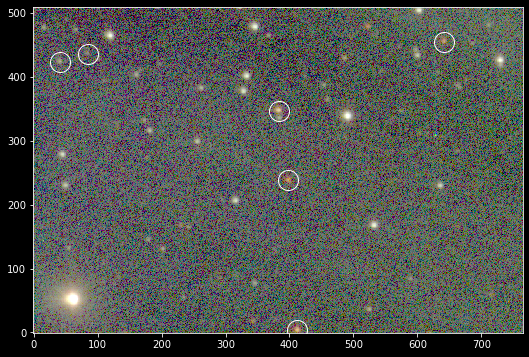

In [36]:
pl.figure(figsize=(10,6))
pl.imshow(rgb_image)
pl.plot(full_table[red_stars]['xcentroid'], full_table[red_stars]['ycentroid'], 'o', mfc='none', mec='white', markersize=20)

# What's in a color-magnitude diagram?

Color-magnitude diagrams are the tools we use to make Hertzsprung-Russell diagrams, i.e., plots that tell us stars' temperatures and luminosities.


To interpret them, we use models of stellar evolution.  We show _isochrones_, which are models where all the stars are the same age - so the most massive stars may be dead, but the lowest-mass stars are on the _main sequence_.  You should recall these terms and concepts from AST 3018/3019!

These isochrones include predictions of the stars' _absolute magnitudes_, which you should recall are the magnitude if the star is at a distance of 10 parsecs.

We will plot the isochrone at the appropriate distance using the _distance modulus_.  H and Chi Persei are at a distance of about 2.3 kpc, or distance modulus

$$\mu = 5 \log(d) - 5$$

In [37]:
distance_modulus = 5 * np.log10(2300) - 5
distance_modulus

11.808639180087965

In [41]:
isochrone1 = Table.read('isochrone.dat', format='ascii', header_start=12, data_start=13)
isochrone1.sort('Vmag')

We plot the isochrone color-magnitude diagram by adding the distance modulus to the V-magnitude.  The color remains unchanged because color is independent of distance (because $B-\mu - (V-\mu) = B-V$).

```
pl.scatter(isochrone1['Bmag'] - isochrone1['Vmag'],
           isochrone1['Vmag'] + distance_modulus)
```

We will colorize the isochrone by the mass.

Then, we overplot our measurements:

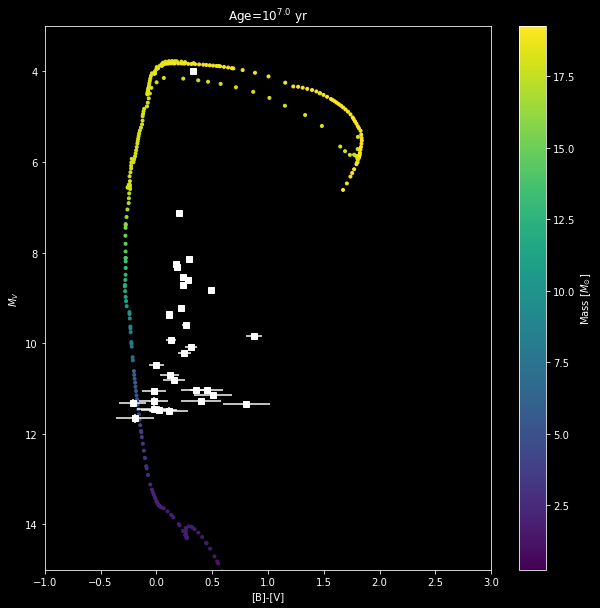

In [42]:
pl.figure(figsize=(10,10))
pl.scatter(isochrone1['Bmag'] - isochrone1['Vmag'],
           isochrone1['Vmag'] + distance_modulus,
           c=isochrone1['Mini'],
           marker='.')
pl.errorbar((Bmag-Vmag)[high_snr], Vmag[high_snr],
            xerr=((eBmag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none', color='w', marker='s')
pl.ylim(15,3); pl.ylabel("$M_V$")
pl.xlim(-1,3); pl.xlabel("[B]-[V]")
pl.title(f'Age=$10^{{{isochrone1["logAge"][0]}}}$ yr')
cb = pl.colorbar()
cb.set_label("Mass [$M_{\odot}$]")

If our measurements are good, and we have the distance right, and all the stars are in the cluster, and we know the age of the cluster, we can use the isochrone model to determine the stars' masses!

The misalignment between our measurements and the isochrone is probably because of _interstellar extinction_, which blocks some of the starlight and changes stars' colors.  We won't worry about that further in this class, though.

That's a lot of caveats, but this is how we measure star cluster ages and star masses.

# Exercise: Overplot different isochrones on the data

I have obtained several additional isochrones from http://stev.oapd.inaf.it/tmp/output518100630565.dat for you to compare to your cluster data.

To start, though, let's compare these isochrons to the CMD you just derived.  Overplot the different age isochrones on the data above:

In [46]:
isochrone2 = Table.read('isochrones.dat', format='ascii')
isochrone2.sort('logAge')
isochrone_100Myr = isochrone2[isochrone2['logAge'] == 8]
isochrone_1Gyr = isochrone2[isochrone2['logAge'] == 9]
isochrone_10Gyr = isochrone2[isochrone2['logAge'] == 10]

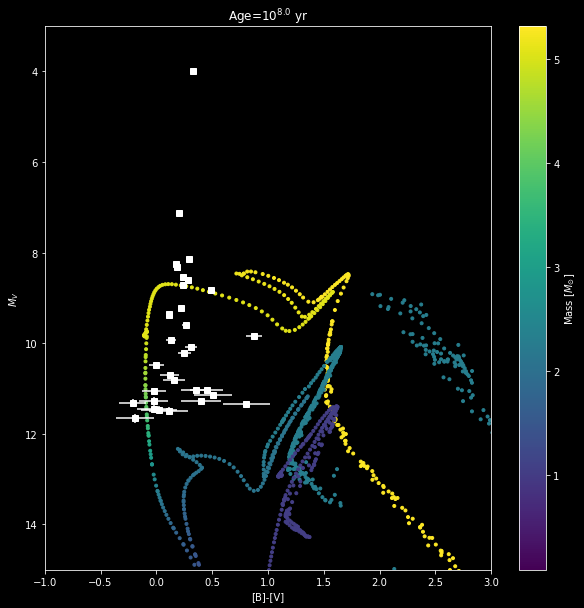

In [48]:
pl.figure(figsize=(10,10))
pl.scatter(isochrone2['Bmag'] - isochrone2['Vmag'],
           isochrone2['Vmag'] + distance_modulus,
           c=isochrone2['Mini'],
           marker='.')
pl.errorbar((Bmag-Vmag)[high_snr], Vmag[high_snr],
            xerr=((eBmag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none', color='w', marker='s')
pl.ylim(15,3); pl.ylabel("$M_V$")
pl.xlim(-1,3); pl.xlabel("[B]-[V]")
pl.title(f'Age=$10^{{{isochrone2["logAge"][0]}}}$ yr')
cb = pl.colorbar()
cb.set_label("Mass [$M_{\odot}$]")

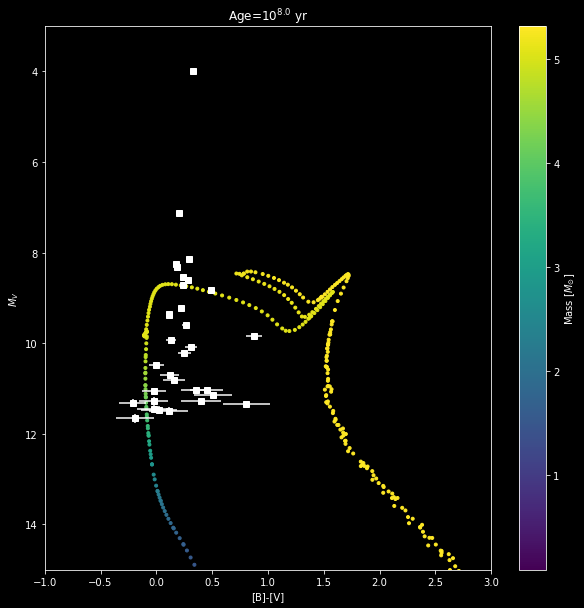

In [49]:
pl.figure(figsize=(10,10))
pl.scatter(isochrone_100Myr['Bmag'] - isochrone_100Myr['Vmag'],
           isochrone_100Myr['Vmag'] + distance_modulus,
           c=isochrone_100Myr['Mini'],
           marker='.')
pl.errorbar((Bmag-Vmag)[high_snr], Vmag[high_snr],
            xerr=((eBmag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none', color='w', marker='s')
pl.ylim(15,3); pl.ylabel("$M_V$")
pl.xlim(-1,3); pl.xlabel("[B]-[V]")
pl.title(f'Age=$10^{{{isochrone_100Myr["logAge"][0]}}}$ yr')
cb = pl.colorbar()
cb.set_label("Mass [$M_{\odot}$]")

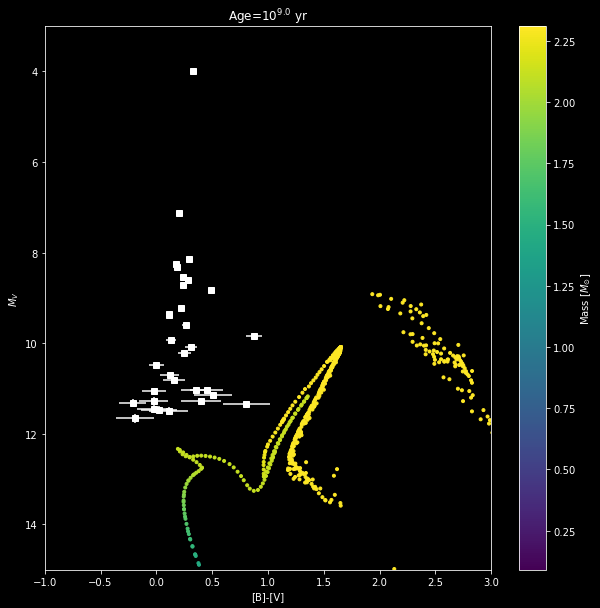

In [50]:
pl.figure(figsize=(10,10))
pl.scatter(isochrone_1Gyr['Bmag'] - isochrone_1Gyr['Vmag'],
           isochrone_1Gyr['Vmag'] + distance_modulus,
           c=isochrone_1Gyr['Mini'],
           marker='.')
pl.errorbar((Bmag-Vmag)[high_snr], Vmag[high_snr],
            xerr=((eBmag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none', color='w', marker='s')
pl.ylim(15,3); pl.ylabel("$M_V$")
pl.xlim(-1,3); pl.xlabel("[B]-[V]")
pl.title(f'Age=$10^{{{isochrone_1Gyr["logAge"][0]}}}$ yr')
cb = pl.colorbar()
cb.set_label("Mass [$M_{\odot}$]")

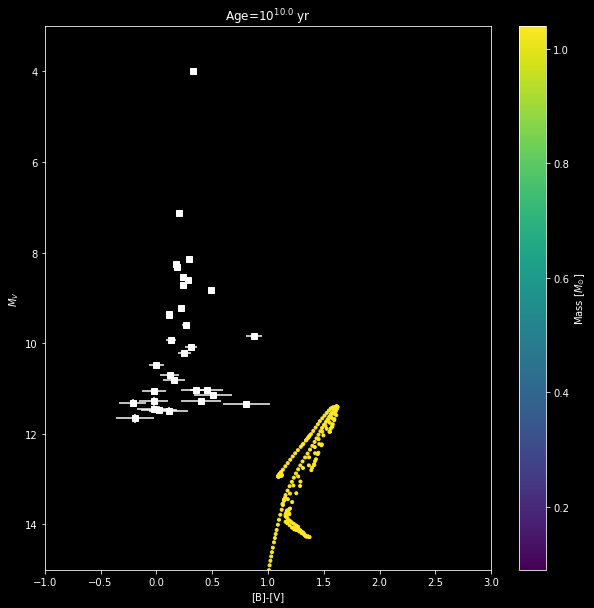

In [51]:
pl.figure(figsize=(10,10))
pl.scatter(isochrone_10Gyr['Bmag'] - isochrone_10Gyr['Vmag'],
           isochrone_10Gyr['Vmag'] + distance_modulus,
           c=isochrone_10Gyr['Mini'],
           marker='.')
pl.errorbar((Bmag-Vmag)[high_snr], Vmag[high_snr],
            xerr=((eBmag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none', color='w', marker='s')
pl.ylim(15,3); pl.ylabel("$M_V$")
pl.xlim(-1,3); pl.xlabel("[B]-[V]")
pl.title(f'Age=$10^{{{isochrone_10Gyr["logAge"][0]}}}$ yr')
cb = pl.colorbar()
cb.set_label("Mass [$M_{\odot}$]")

Once you've done this, assess: Can you say anything about the observed cluster's age?

The cluster has an age of around 100Myr because our data points match most closely and show most prominently on he first graph. Extenction causes the data to not show as well as it would otherwise. Since the 100Myr fit doesn't fit very well, we can probably sat that the cluster is younger than 100 Myr because as you go forward in time, the fit gets worse.